In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras import layers

import tensorflow as tf


In [10]:
train=pd.read_csv('twitter_training.csv', encoding='ISO-8859-1')
test=pd.read_csv('twitter_validation.csv', encoding='ISO-8859-1')

In [11]:
train

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


C:\Users\marji\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\marji\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\marji\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


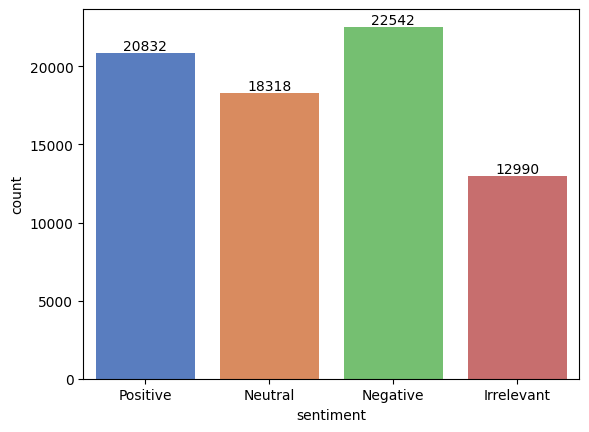

In [12]:
ax = sns.countplot(x='sentiment', data=train, palette='muted')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [13]:
train["entity"] = train["entity"].apply(str)
train["sentiment"] = train["sentiment"].astype("category")
train["tweet"] = train["tweet"].apply(str)

test["entity"] = test["entity"].apply(str)
test["sentiment"] = test["sentiment"].astype("category")
test["tweet"] = test["tweet"].apply(str)

In [14]:
def cleaning_tweets(tweet):
    #Removing all the @ mentions from the tweets
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet)
    
    #Removing the links from the tweets
    tweet = re.sub(r"https?://[A-Za-z0-9./]+","", tweet)
    
    #Removing unnecesarry characters like emojis from the tweets
    tweet = re.sub(r"[^ A-Za-z0-9.!?']","", tweet)
    
    #Removing any extra whitespaces
    tweet = re.sub(r" +"," ", tweet)
    
    return tweet

In [15]:
clean_tweets = [cleaning_tweets(tweet) for tweet in train['tweet']]
train['clean_tweets'] = clean_tweets

clean_tweets = [cleaning_tweets(tweet) for tweet in test['tweet']]
test['clean_tweets'] = clean_tweets

In [16]:
cols = ['tweet','id','entity']
train.drop(cols, axis = 1, inplace = True)
test.drop(cols, axis = 1, inplace = True)

In [17]:
label_encoder = LabelEncoder() 
label_encoder.fit(train["sentiment"])

train["sentiment"]= label_encoder.transform(train["sentiment"])
test["sentiment"]= label_encoder.transform(test["sentiment"])

In [20]:
pip install tensorflow_datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 57.6/57.6 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
    --------------------------------------- 0.1/5.1 MB 5.1 MB/s eta 0:00:01
   -- ------------------------------------- 0.3/5.1 MB 3.7 MB/s eta 0:00:02
   ---- ----------------------------------- 0.6/5.1 MB 4.0 MB/s eta 0:00:02
   ------- -------------------------------- 1.0/5.1 MB 5.7 MB/s eta 0:00:01
   --------- ------------------------------ 1.2/5.1 MB 5.6 MB/s eta 0:00:01
   --------- ------------------------------ 1.2/5.1 MB 5.6 MB/s eta 0:00:01
   -------------- ------------------------- 1.8/5.1 MB 5.8 MB/s eta 0:00:01
   ------------------- -------------------- 2.5/5.1 MB 7.0 MB/s e

  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import tensorflow_datasets as tfds

In [22]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train["clean_tweets"], target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in train["clean_tweets"]]

In [23]:
max_len = max(len(sentence) for sentence in data_inputs)

data_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    data_inputs, value=0, padding="post",maxlen=max_len
)

In [24]:
test_inputs = [tokenizer.encode(sentence) for sentence in test["clean_tweets"]]

# Pad sequences in the test data
test_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    test_inputs, value=0, padding="post", maxlen=max_len
)

In [25]:
class DCNN(tf.keras.Model):
    
    #Initializer method
    def __init__(self,
                 vocab_size,       #vocab_size: The size of the vocabulary.
                 emb_dim=128,      #emb_dim: The dimensionality of the embedding space.
                 nb_filters=50,    #nb_filters: The number of filters in the convolutional layers.
                 FFN_units=512,    #FFN_units: The number of units in the feedforward neural network layer.
                 nb_classes=4,     #nb_classes: The number of output classes.
                 dropout_rate=0.3, #The dropout rate for regularization.
                 training=False,   #training: A boolean indicating whether the model is in training mode or not.
                 name="dcnn"):     #name: The name of the model.
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim) #Embedding layer: To learn the embeddings for input tokens.
        
        #Convolutional layers (bigram, trigram, quadgram): To capture different n-gram features/filters in the input.
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 2,
                                    padding="same",
                                    activation="relu")
        
        #GlobalMaxPool1D layers: To pool the maximum value across the temporal dimension after convolution.
        self.pool_1 = layers.GlobalMaxPool1D()
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 3,
                                    padding="same",
                                    activation="relu")
        self.pool_2 = layers.GlobalMaxPool1D()
        
        self.quadgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 4,
                                    padding="same",
                                    activation="relu")
        self.pool_3 = layers.GlobalMaxPool1D()
        
        #Dense layers: Fully connected layers for further processing.
        self.dense_1 = layers.Dense(units = FFN_units, activation="relu")
        
        #Dropout layer: For regularization by randomly dropping units during training.
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        #Last Dense Layer: For output
        self.last_dense = layers.Dense(units = nb_classes, activation="softmax")
        
    #This method defines the forward pass of the model.
    def call(self, inputs, training):

        #The embeddings are first extracted from the input tokens using the Embedding layer.
        x = self.embedding(inputs)
        
        #The embedded sequences are then passed through convolutional layers (bigram, trigram, quadgram) 
        #followed by max-pooling layers (pool_1, pool_2, pool_3).
        x_1 = self.bigram(x)
        x_1 = self.pool_1(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool_2(x_2)
        x_3 = self.quadgram(x)
        x_3 = self.pool_3(x_3)

        #The outputs from these layers are concatenated along the feature axis (axis=-1).
        merged = tf.concat([x_1,x_2,x_3], axis=-1)
        
        #The concatenated features are passed through a dense layer (dense_1) followed by a dropout layer (dropout) for regularization.

        merged = self.dense_1(merged)
        merged = self.dropout(merged,training = training)
        
        #Finally, the output is passed through a dense layer (last_dense) with softmax activation to produce the final classification probabilities.
        output = self.last_dense(merged)
        
        return output

In [26]:
dcnn = DCNN(vocab_size = tokenizer.vocab_size)

In [27]:
dcnn.compile(loss="sparse_categorical_crossentropy", optimizer="Adam",metrics=["sparse_categorical_accuracy"])

In [28]:
dcnn.fit(data_inputs, train['sentiment'], batch_size=128, epochs=10)

Epoch 1/10
584/584 [==============================] - 80s 135ms/step - loss: 0.7197 - sparse_categorical_accuracy: 0.7091
Epoch 2/10
584/584 [==============================] - 78s 134ms/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9468
Epoch 3/10
584/584 [==============================] - 80s 136ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9691
Epoch 4/10
584/584 [==============================] - 79s 136ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9723
Epoch 5/10
584/584 [==============================] - 79s 136ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9735
Epoch 6/10
584/584 [==============================] - 79s 135ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9737
Epoch 7/10
584/584 [==============================] - 79s 135ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9729
Epoch 8/10
584/584 [==============================] - 79s 135ms/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9664
Epoch 9/10
584/584 [====

In [29]:
# Evaluate the model on the test data
loss, accuracy = dcnn.evaluate(test_inputs, test['sentiment'], batch_size=128)

# Print the evaluation metrics
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

8/8 [==============================] - 0s 15ms/step - loss: 0.3469 - sparse_categorical_accuracy: 0.9480
Test Loss: 0.3468656539916992
Test Accuracy: 0.9480000138282776
